In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pymystem3

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# from scipy.cluster.hierarchy import ward, fcluster
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
# import torch

import re
from pymystem3 import Mystem
import pymystem3
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer
# from wordcloud import WordCloud
import matplotlib.pyplot as plt

# from sklearn.cluster import AgglomerativeClustering
# from sklearn.manifold import TSNE
# import plotly.graph_objects as go

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
X_train = pd.read_csv('/content/drive/My Drive/data/nlp/X_train.csv', sep=';', index_col=0)
X_test = pd.read_csv('/content/drive/My Drive/data/nlp/X_test.csv', sep=';', index_col=0)
test_data = pd.read_csv('/content/drive/My Drive/data/nlp/test_data.csv', sep=';', index_col=0)

In [ ]:
X_train


,content,name,owners,model_score
27887,i miss csgo,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000",0.252871
89458,2/10 no fish ai,Counter-Strike: Source,"10,000,000 .. 20,000,000",0.791153
47101,"This game is so silly because I shoot the ""inf...",Left 4 Dead 2,"50,000,000 .. 100,000,000",0.489242
18725,You've managed to make me not care about the c...,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000",0.444210
21403,I don't recommend this because Left 4 Dead 2 i...,Left 4 Dead,"5,000,000 .. 10,000,000",0.000905
...,...,...,...,...
34460,Childhood game DABEEESSSTTTTTT!!!!,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.500135
135653,ive loved the game since i started out on a cr...,Counter-Strike,"10,000,000 .. 20,000,000",0.800582
17015,Any Half Life fan of course needs to play this!,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.736046
74027,i hate that disgusting fat motherfucker that i...,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.496303


In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english') + stopwords.words('russian'))

In [ ]:
import re
from pymystem3 import Mystem
import multiprocessing as mp
from tqdm import tqdm

# === 0. Предустановка mystem ===
# Вызываем один раз в основном процессе, чтобы бинарник скачался/распаковался
# и был доступен всем child-process.
_mystem_global = Mystem()
_mystem_global.close()  # сразу закрываем, будем инициализировать в get_mystem

# === 1. Глобальный Mystem в каждом процессе ===
_mystem = None
def get_mystem():
    global _mystem
    if _mystem is None:
        # Указываем, что бинарник уже есть — pymystem3 не станет ставить заново
        _mystem = Mystem()
    return _mystem

def process_document(idx: int, document: str, stopset: set[str], tokenizer) -> str:
    tokenized = tokenizer.tokenize(document)
    filtered = [t.lower() for t in tokenized
                if re.match(r'^[a-zа-я]+$', t.lower())
                   and t.lower() not in stopset
                   and len(t) > 1]

    joined = ' '.join(filtered)
    lemmas = get_mystem().lemmatize(joined)
    lemmatized = ''.join(lemmas).replace('\n', ' ')
    # final = [w for w in lemmatized.split() if w not in stopset]
    return lemmatized

def _star_process(args):
    return process_document(*args)

def words_to_cloud(
    documents: list[str],
    stopwords: list[str],
    tokenizer,
    n_jobs: int = 4
) -> list[str]:
    stopset = set(stopwords)
    args = [(i, doc, stopset, tokenizer) for i, doc in enumerate(documents)]
    results: list[str] = []
    # создаём пул _после_ того, как mystem предустановлен
    with mp.Pool(processes=n_jobs) as pool:
        for processed in tqdm(
            pool.imap(_star_process, args),
            total=len(args),
            desc="Обработка документов",
            unit="doc"
        ):
            results.append(processed)
    return results


In [ ]:
docs = X_train['content'].astype(str).str.lower().tolist()
tokenizer = TweetTokenizer()

# --- 2. Вызов функции ---
processed_docs = words_to_cloud(
    documents=docs,
    stopwords=stop_words,
    tokenizer=tokenizer,
    n_jobs= 16  # сколько процессов задействовать
)


Обработка документов: 100%|██████████| 112644/112644 [00:23<00:00, 4832.50doc/s]


In [ ]:
processed_docs

['miss csgo ',
 'fish ai ',
 'game silly shoot infected people go aaieeehageegh mention also shoot tank throw rock get mad good game ',
 'managed make care continuation ending ip enjoyed decades congratulations ',
 'recommend left dead superior every way making game pointless buy everything game ',
 'pvp version half life combat community dead anyone dedicated enough play probably hacker making youtube video might worth play bunch friends better games sort thing still good half life good ',
 'bad game ',
 'masterpiece continuation portal series first much content original actually took hours beat complex portals bad way admit times throws many puzzles contributing story feel like filler get actually got game steam summer sale really steal lots mods game like portal revolution add even content game check finish one story best game experienced even main characters much work devs put story end buy chuck money valve maybe make portal although know valve count three ',
 'good game gg na sir

In [ ]:
X_train['clean_content'] = processed_docs

In [ ]:
docs = X_test['content'].astype(str).str.lower().tolist()
tokenizer = TweetTokenizer()

# --- 2. Вызов функции ---
processed_docs = words_to_cloud(
    documents=docs,
    stopwords=stop_words,
    tokenizer=tokenizer,
    n_jobs= 16  # сколько процессов задействовать
)


Обработка документов: 100%|██████████| 28161/28161 [00:07<00:00, 3612.56doc/s]


In [ ]:
X_test['clean_content'] = processed_docs

In [ ]:
docs = test_data['content'].astype(str).str.lower().tolist()
tokenizer = TweetTokenizer()

# --- 2. Вызов функции ---
processed_docs = words_to_cloud(
    documents=docs,
    stopwords=stop_words,
    tokenizer=tokenizer,
    n_jobs= 16  # сколько процессов задействовать
)


Обработка документов: 100%|██████████| 60346/60346 [00:13<00:00, 4355.23doc/s]


In [ ]:
test_data['clean_content'] = processed_docs

In [ ]:
X_train.to_csv('/content/drive/My Drive/data/nlp/X_train_words.csv', sep=';')
X_test.to_csv('/content/drive/My Drive/data/nlp/X_test_words.csv', sep=';')
test_data.to_csv('/content/drive/My Drive/data/nlp/test_data_words.csv', sep=';')

# 1

In [ ]:
X_train = pd.read_csv('/content/drive/My Drive/data/nlp/X_train_words.csv', sep=';', index_col=0)
X_test = pd.read_csv('/content/drive/My Drive/data/nlp/X_test_words.csv', sep=';', index_col=0)
test_data = pd.read_csv('/content/drive/My Drive/data/nlp/test_data_words.csv', sep=';', index_col=0)

In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/data/nlp/test_data_words.csv', sep=';', index_col=0)

In [ ]:
X_train

,content,name,owners,model_score,clean_content
27887,i miss csgo,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000",0.252871,miss csgo
89458,2/10 no fish ai,Counter-Strike: Source,"10,000,000 .. 20,000,000",0.791153,fish ai
47101,"This game is so silly because I shoot the ""inf...",Left 4 Dead 2,"50,000,000 .. 100,000,000",0.489242,game silly shoot infected people go aaieeehage...
18725,You've managed to make me not care about the c...,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000",0.444210,managed make care continuation ending ip enjoy...
21403,I don't recommend this because Left 4 Dead 2 i...,Left 4 Dead,"5,000,000 .. 10,000,000",0.000905,recommend left dead superior every way making ...
...,...,...,...,...,...
34460,Childhood game DABEEESSSTTTTTT!!!!,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.500135,childhood game dabeeessstttttt
135653,ive loved the game since i started out on a cr...,Counter-Strike,"10,000,000 .. 20,000,000",0.800582,ive loved game since started cracked version c...
17015,Any Half Life fan of course needs to play this!,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.736046,half life fan course needs play
74027,i hate that disgusting fat motherfucker that i...,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.496303,hate disgusting fat motherfucker always blowin...


In [ ]:
X_train.isna().sum()

,0
content,254
name,5121
owners,5121
model_score,0
clean_content,5808


In [ ]:
X_train = X_train.fillna('-')
X_test = X_test.fillna('-')
test_data = test_data.fillna('-')

In [ ]:
from collections import Counter
import re

all_tokens = (' '.join(X_train['clean_content'].fillna('-').values)).split()
counter = Counter(all_tokens)

# Выводим число уникальных слов
print(f"Уникальных слов: {len(counter)}")

Уникальных слов: 54684


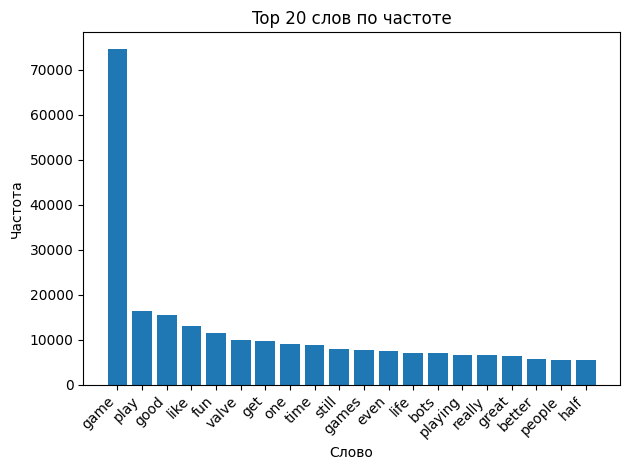

In [ ]:
top_n = 20
common = counter.most_common(top_n)
words, freqs = zip(*common)

# Строим столбчатый график
plt.figure()
plt.bar(range(top_n), freqs)
plt.xticks(range(top_n), words, rotation=45, ha='right')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.title(f'Top {top_n} слов по частоте')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = X_train['clean_content'].astype(str).tolist()
vectorizer = TfidfVectorizer(
    max_features=3000,      # оставляем только 5000 наиболее «значимых» слов
    lowercase=False,        # тексты уже приведены к нижнему регистру, либо можно True
    ngram_range=(1, 2),
)

In [ ]:
X_tfidf = vectorizer.fit_transform(texts)

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_train.index
)

In [ ]:
X_train = pd.concat([X_train, tfidf_df.drop(['name', 'content', 'owners'], axis=1, errors='ignore')], axis=1)


In [ ]:

test_texts  = X_test ['clean_content'].astype(str).tolist()

X_test_tfidf = vectorizer.transform(test_texts)

test_tfidf_df = pd.DataFrame(
    X_test_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_test.index
)

# 6. Конкатенируем к X_test
X_test = pd.concat([X_test, test_tfidf_df.drop(['name', 'content', 'owners'], axis=1,  errors='ignore')], axis=1)

In [ ]:
y_train = pd.read_csv('/content/drive/My Drive/data/nlp/y_train.csv', index_col=0, sep=';')
y_test = pd.read_csv('/content/drive/My Drive/data/nlp/y_test.csv', index_col=0, sep=';')

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
y_train

,is_positive
27887,0
89458,0
47101,1
18725,0
21403,0
...,...
34460,1
135653,1
17015,1
74027,1


In [ ]:
from catboost import CatBoostClassifier
# с n_grams
model_ = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100,
    cat_features=['name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_train.drop(['content', 'clean_content'], axis=1),
    y_train,
    use_best_model=True,
    # plot=True
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6140518	total: 404ms	remaining: 13m 27s
100:	learn: 0.2629474	total: 33.6s	remaining: 10m 31s
200:	learn: 0.2452541	total: 1m 5s	remaining: 9m 44s
300:	learn: 0.2348150	total: 1m 36s	remaining: 9m 7s
400:	learn: 0.2273088	total: 2m 6s	remaining: 8m 25s
500:	learn: 0.2208423	total: 2m 36s	remaining: 7m 46s
600:	learn: 0.2157332	total: 3m 5s	remaining: 7m 12s
700:	learn: 0.2113739	total: 3m 34s	remaining: 6m 37s
800:	learn: 0.2074687	total: 4m 3s	remaining: 6m 4s
900:	learn: 0.2038149	total: 4m 32s	remaining: 5m 32s
1000:	learn: 0.2006165	total: 5m 1s	remaining: 5m 1s
1100:	learn: 0.1973281	total: 5m 30s	remaining: 4m 29s
1200:	learn: 0.1944541	total: 5m 59s	remaining: 3m 59s
1300:	learn: 0.1917835	total: 6m 28s	remaining: 3m 28s
1400:	learn: 0.1890123	total: 6m 57s	remaining: 2m 58s
1500:	learn: 0.1865966	total: 7m 26s	remaining: 2m 28s
1600:	learn: 0.1841228	total: 7m 55s	remaining: 1m 58s
1700:	learn: 0.1818542	total: 8m 24s	remaining: 1m 28s
1800:	learn: 0.1797215	total: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model_.predict(X_test.drop(['content', 'clean_content'], axis=1))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# невероятные метрики, даже без анализа текста :)

Accuracy: 0.9033059905543127

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90     13788
           1       0.89      0.93      0.91     14373

    accuracy                           0.90     28161
   macro avg       0.90      0.90      0.90     28161
weighted avg       0.90      0.90      0.90     28161


Confusion Matrix:
 [[12064  1724]
 [  999 13374]]


In [ ]:
test_data['content_length'] = test_data['content'].str.len().fillna(0)
test_data['open_paren_count']  = test_data['content'].str.count(r'\(').fillna(0)
test_data['close_paren_count'] = test_data['content'].str.count(r'\)').fillna(0)

test_data['exclamation_count'] = test_data['content'].str.count(r'!').fillna(0)
test_data['question_count']    = test_data['content'].str.count(r'\?').fillna(0)

test_data['digit_count'] = test_data['content'].str.count(r'\d').fillna(0)

test_data['uppercase_word_count'] = test_data['content'].astype(str).apply(
        lambda text: sum(1 for w in text.split() if w.isupper())
).fillna(0)

test_data['punctuation_count'] = test_data['content'].str.count(r'[^\w\s]').fillna(0)

In [ ]:
test_data = test_data.drop('id', axis=1)

In [ ]:
test_texts  = test_data ['clean_content'].astype(str).tolist()

test_data_tfidf = vectorizer.transform(test_texts)

test_tfidf_df = pd.DataFrame(
    test_data_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=test_data.index
)

# 6. Конкатенируем к test_data
test_data = pd.concat([test_data, test_tfidf_df.drop(['name', 'content', 'owners'], axis=1,  errors='ignore')], axis=1)

In [ ]:
test_data.shape

(60346, 3011)

In [ ]:
features = X_train.drop(['content', 'clean_content'], axis=1).columns.tolist()

In [ ]:
predictions = model_.predict(test_data[features])

In [ ]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'sentiment': predictions
})

submission.to_csv('/content/drive/My Drive/data/nlp/submission.csv', index=False)


In [ ]:
X_train['content_length'] = X_train['content'].str.len().fillna(0)
X_train['open_paren_count']  = X_train['content'].str.count(r'\(').fillna(0)
X_train['close_paren_count'] = X_train['content'].str.count(r'\)').fillna(0)

X_train['exclamation_count'] = X_train['content'].str.count(r'!').fillna(0)
X_train['question_count']    = X_train['content'].str.count(r'\?').fillna(0)

X_train['digit_count'] = X_train['content'].str.count(r'\d').fillna(0)

X_train['uppercase_word_count'] = X_train['content'].astype(str).apply(
        lambda text: sum(1 for w in text.split() if w.isupper())
).fillna(0)

X_train['punctuation_count'] = X_train['content'].str.count(r'[^\w\s]').fillna(0)

In [ ]:
X_test['content_length'] = X_test['content'].str.len().fillna(0)
X_test['open_paren_count']  = X_test['content'].str.count(r'\(').fillna(0)
X_test['close_paren_count'] = X_test['content'].str.count(r'\)').fillna(0)

X_test['exclamation_count'] = X_test['content'].str.count(r'!').fillna(0)
X_test['question_count']    = X_test['content'].str.count(r'\?').fillna(0)

X_test['digit_count'] = X_test['content'].str.count(r'\d').fillna(0)

X_test['uppercase_word_count'] = X_test['content'].astype(str).apply(
        lambda text: sum(1 for w in text.split() if w.isupper())
).fillna(0)

X_test['punctuation_count'] = X_test['content'].str.count(r'[^\w\s]').fillna(0)


In [ ]:
from catboost import CatBoostClassifier

model_ = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100,
    cat_features=['name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_train.drop(['content', 'clean_content'], axis=1),
    y_train,
    use_best_model=True,
    # plot=True
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.5894545	total: 454ms	remaining: 7m 33s
100:	learn: 0.2625735	total: 39s	remaining: 5m 47s
200:	learn: 0.2455255	total: 1m 13s	remaining: 4m 53s
300:	learn: 0.2352257	total: 1m 47s	remaining: 4m 10s
400:	learn: 0.2274957	total: 2m 20s	remaining: 3m 30s
500:	learn: 0.2214381	total: 2m 53s	remaining: 2m 52s
600:	learn: 0.2160160	total: 3m 25s	remaining: 2m 16s
700:	learn: 0.2117639	total: 3m 57s	remaining: 1m 41s
800:	learn: 0.2078574	total: 4m 29s	remaining: 1m 7s
900:	learn: 0.2043970	total: 5m 1s	remaining: 33.2s
999:	learn: 0.2012761	total: 5m 33s	remaining: 0us


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model_.predict(X_test.drop(['content', 'clean_content'], axis=1))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# невероятные метрики, даже без анализа текста :)

Accuracy: 0.9023827278860835

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90     13788
           1       0.88      0.93      0.91     14373

    accuracy                           0.90     28161
   macro avg       0.90      0.90      0.90     28161
weighted avg       0.90      0.90      0.90     28161


Confusion Matrix:
 [[12002  1786]
 [  963 13410]]


In [ ]:
from catboost import CatBoostClassifier

model_ = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100,
    cat_features=['name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_train.drop(['content', 'clean_content'], axis=1),
    y_train,
    use_best_model=True,
    # plot=True
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.5907092	total: 388ms	remaining: 6m 27s
100:	learn: 0.2639659	total: 32.3s	remaining: 4m 47s
200:	learn: 0.2473221	total: 1m 4s	remaining: 4m 16s
300:	learn: 0.2375131	total: 1m 36s	remaining: 3m 44s
400:	learn: 0.2302168	total: 2m 8s	remaining: 3m 11s
500:	learn: 0.2241820	total: 2m 36s	remaining: 2m 35s
600:	learn: 0.2195644	total: 3m 4s	remaining: 2m 2s
700:	learn: 0.2154236	total: 3m 33s	remaining: 1m 30s
800:	learn: 0.2118250	total: 4m 3s	remaining: 1m
900:	learn: 0.2082783	total: 4m 31s	remaining: 29.9s
999:	learn: 0.2052210	total: 4m 58s	remaining: 0us


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model_.predict(X_test.drop(['content', 'clean_content'], axis=1))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# невероятные метрики, даже без анализа текста :)

Accuracy: 0.9014594652178545

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90     13788
           1       0.88      0.93      0.91     14373

    accuracy                           0.90     28161
   macro avg       0.90      0.90      0.90     28161
weighted avg       0.90      0.90      0.90     28161


Confusion Matrix:
 [[11961  1827]
 [  948 13425]]


In [ ]:

importances = model_.feature_importances_
#    Если модель — CatBoostClassifier, то:
# importances = model_.get_feature_importance()

# 2. Берём список имён признаков из X_train (или из того DataFrame, на котором учили)
feature_names = features

# 3. Формируем DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# 4. Сортируем по убыванию важности
fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 5. Сохраняем в CSV
fi_df.to_csv("/content/drive/My Drive/data/nlp/feature_importances.csv", index=False)

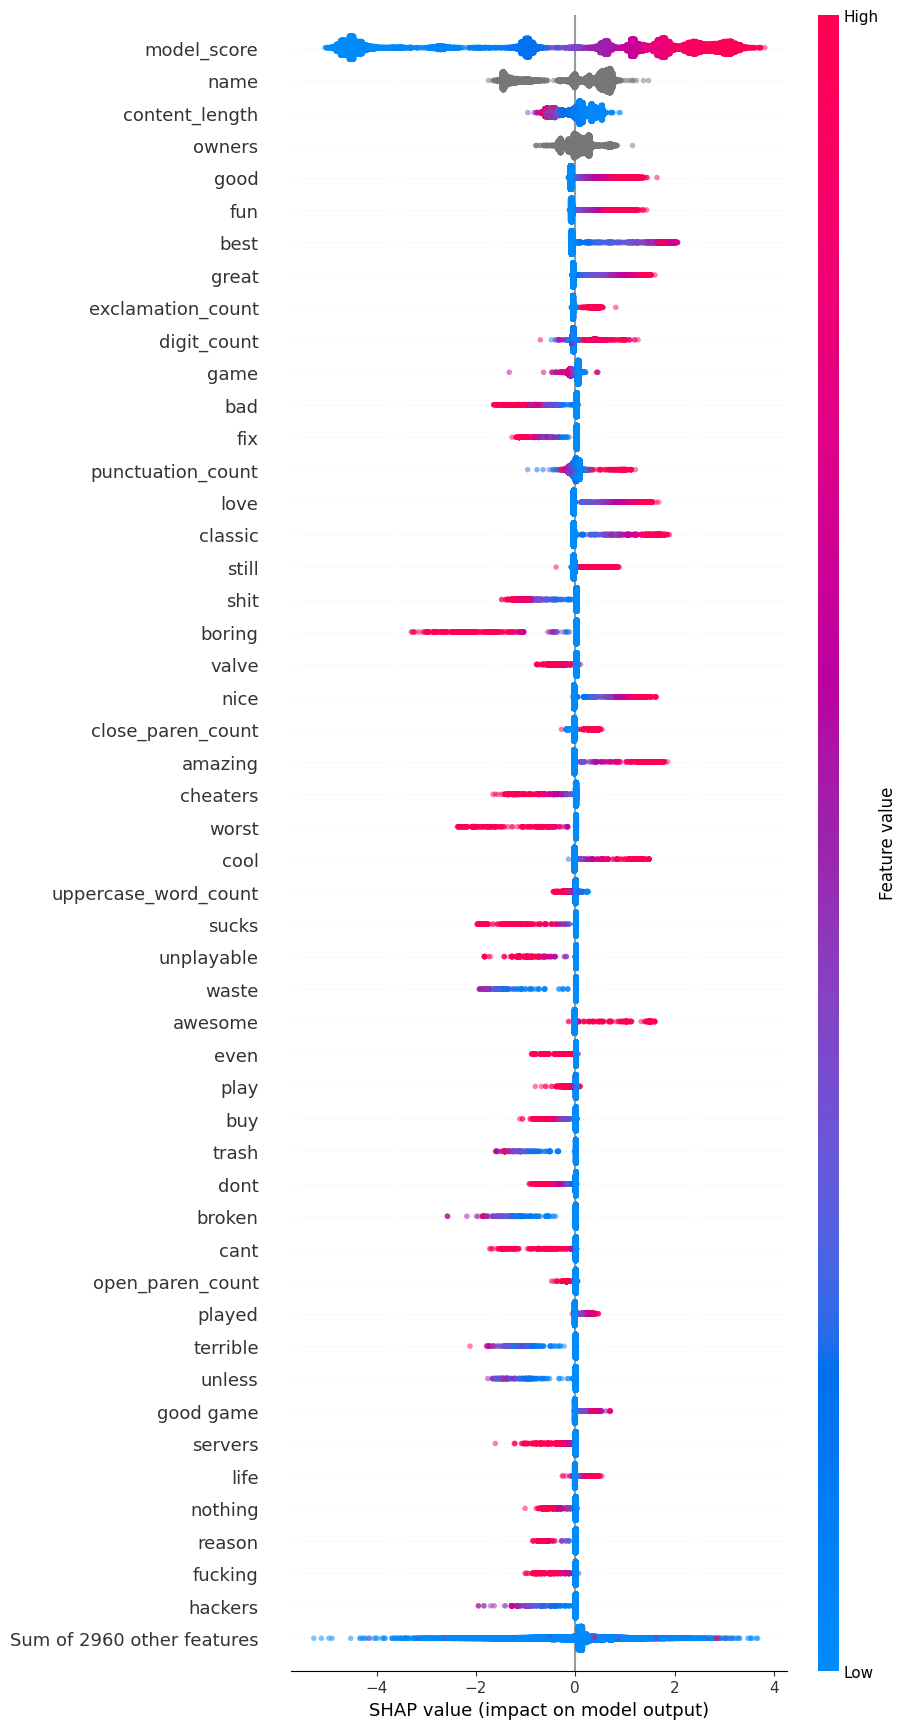

In [ ]:
import shap
explainer = shap.Explainer(model_)

shap_values = explainer(X_test.drop(['content', 'clean_content'], axis=1))
shap.plots.beeswarm(shap_values, max_display=50, alpha=0.5, show=False)
plt.show()


In [ ]:
importances = model_.get_feature_importance()
sorted(importances, reverse=True)[:150]

[np.float64(58.19024699901064),
 np.float64(3.220073267251997),
 np.float64(1.7398305514143282),
 np.float64(1.340672099490602),
 np.float64(1.1883091168815123),
 np.float64(1.0203388037970134),
 np.float64(0.9773156188116352),
 np.float64(0.9141789118164364),
 np.float64(0.7736564579115299),
 np.float64(0.6576270863361559),
 np.float64(0.6454515762734153),
 np.float64(0.6095850171518934),
 np.float64(0.6019371521675096),
 np.float64(0.5681371882730945),
 np.float64(0.5589172045968294),
 np.float64(0.5383252281008669),
 np.float64(0.5287201604050523),
 np.float64(0.5001146280104714),
 np.float64(0.461107863192483),
 np.float64(0.45398711164486005),
 np.float64(0.4166257574998229),
 np.float64(0.41647441493474846),
 np.float64(0.4150936905008116),
 np.float64(0.4015667878232118),
 np.float64(0.35458189465955936),
 np.float64(0.3470588438651601),
 np.float64(0.3451060912175046),
 np.float64(0.33436129666714426),
 np.float64(0.30462307997228466),
 np.float64(0.2901614287655719),
 np.float

In [ ]:
importances = model_.get_feature_importance()
sorted(importances, reverse=False)[1500:1550]

[np.float64(0.0008934262446890768),
 np.float64(0.0008977553172259047),
 np.float64(0.0009010626313745715),
 np.float64(0.0009040663469690487),
 np.float64(0.0009117432087313457),
 np.float64(0.0009165120019791796),
 np.float64(0.0009240118530855994),
 np.float64(0.0009242602261073599),
 np.float64(0.0009267240475699925),
 np.float64(0.0009301478209530885),
 np.float64(0.0009363212913303782),
 np.float64(0.0009370871305117167),
 np.float64(0.0009417394191206537),
 np.float64(0.0009467545171594503),
 np.float64(0.0009491315979412188),
 np.float64(0.0009575211366864005),
 np.float64(0.0009608530127304516),
 np.float64(0.0009608904064851362),
 np.float64(0.0009617962137870949),
 np.float64(0.0009623416901348718),
 np.float64(0.0009683180330566697),
 np.float64(0.0009698844341017481),
 np.float64(0.0009711288445063396),
 np.float64(0.0009714146146249988),
 np.float64(0.0009870210191504367),
 np.float64(0.0009880876407540593),
 np.float64(0.0009888857568886222),
 np.float64(0.00099080472024

## 100 слов

In [ ]:
texts = X_train['clean_content'].astype(str).tolist()
vectorizer = TfidfVectorizer(
    max_features=100,      # оставляем только 5000 наиболее «значимых» слов
    lowercase=False,        # тексты уже приведены к нижнему регистру, либо можно True
)

In [ ]:
X_tfidf = vectorizer.fit_transform(texts)

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_train.index
)


In [ ]:
X_train = pd.concat([X_train, tfidf_df], axis=1)


In [ ]:

test_texts  = X_test ['clean_content'].astype(str).tolist()

X_test_tfidf = vectorizer.transform(test_texts)

test_tfidf_df = pd.DataFrame(
    X_test_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_test.index
)

# 6. Конкатенируем к X_test
X_test = pd.concat([X_test, test_tfidf_df], axis=1)

In [ ]:
X_train['also']

,also
27887,0.000000
89458,0.000000
47101,0.461295
18725,0.000000
21403,0.000000
...,...
34460,0.000000
135653,0.000000
17015,0.000000
74027,0.000000


In [ ]:
from catboost import CatBoostClassifier

model_ = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100,
    cat_features=['name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_train.drop(['content', 'clean_content'], axis=1),
    y_train,
    use_best_model=True,
    # plot=True
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6107337	total: 74.5ms	remaining: 2m 28s
100:	learn: 0.2782508	total: 5.69s	remaining: 1m 47s
200:	learn: 0.2681454	total: 10.9s	remaining: 1m 37s
300:	learn: 0.2614015	total: 16.1s	remaining: 1m 30s
400:	learn: 0.2562546	total: 21.4s	remaining: 1m 25s


KeyboardInterrupt: 

In [ ]:

y_pred = model_.predict(X_test.drop(['content', 'clean_content'], axis=1))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8805440147722027

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87     13788
           1       0.86      0.92      0.89     14373

    accuracy                           0.88     28161
   macro avg       0.88      0.88      0.88     28161
weighted avg       0.88      0.88      0.88     28161


Confusion Matrix:
 [[11546  2242]
 [ 1122 13251]]


## тыща

In [ ]:
texts = X_train['clean_content'].astype(str).tolist()
vectorizer = TfidfVectorizer(
    max_features=1000,      # оставляем только 5000 наиболее «значимых» слов
    lowercase=False,        # тексты уже приведены к нижнему регистру, либо можно True
    ngram_range=(1, 2),
)

In [ ]:
X_tfidf = vectorizer.fit_transform(texts)

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_train.index
)


In [ ]:
X_train = pd.concat([X_train, tfidf_df.drop(['name', 'content', 'owners'], axis=1, errors='ignore')], axis=1)


In [ ]:

test_texts  = X_test ['clean_content'].astype(str).tolist()

X_test_tfidf = vectorizer.transform(test_texts)

test_tfidf_df = pd.DataFrame(
    X_test_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_test.index
)

# 6. Конкатенируем к X_test
X_test = pd.concat([X_test, test_tfidf_df.drop(['name', 'content', 'owners'], axis=1, errors='ignore')], axis=1)

In [ ]:
from catboost import CatBoostClassifier

model_ = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100,
    cat_features=['name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_train.drop(['content', 'clean_content'], axis=1),
    y_train,
    use_best_model=True,
    # plot=True
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6129211	total: 209ms	remaining: 3m 28s
100:	learn: 0.2637670	total: 19.9s	remaining: 2m 57s
200:	learn: 0.2478269	total: 39.5s	remaining: 2m 36s
300:	learn: 0.2382637	total: 58.2s	remaining: 2m 15s
400:	learn: 0.2308568	total: 1m 17s	remaining: 1m 55s
500:	learn: 0.2253359	total: 1m 35s	remaining: 1m 35s
600:	learn: 0.2206499	total: 1m 53s	remaining: 1m 15s
700:	learn: 0.2163977	total: 2m 12s	remaining: 56.4s
800:	learn: 0.2123694	total: 2m 30s	remaining: 37.4s
900:	learn: 0.2089386	total: 2m 48s	remaining: 18.6s
999:	learn: 0.2057027	total: 3m 6s	remaining: 0us


In [ ]:

y_pred = model_.predict(X_test.drop(['content', 'clean_content'], axis=1))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8986541671105429

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     13788
           1       0.88      0.93      0.90     14373

    accuracy                           0.90     28161
   macro avg       0.90      0.90      0.90     28161
weighted avg       0.90      0.90      0.90     28161


Confusion Matrix:
 [[11925  1863]
 [  991 13382]]


# with PCA


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = X_train['clean_content'].astype(str).tolist()
vectorizer = TfidfVectorizer(
    max_features=10000,      # оставляем только 5000 наиболее «значимых» слов
    lowercase=False,        # тексты уже приведены к нижнему регистру, либо можно True
    ngram_range=(1, 3),
)

In [ ]:
X_tfidf = vectorizer.fit_transform(texts)

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_train.index
)

In [ ]:
X_train = pd.concat([X_train, tfidf_df.drop(['name', 'content', 'owners', 'clean_content'], axis=1, errors='ignore')], axis=1)


In [ ]:
X_train

,content,name,owners,model_score,clean_content,aaa,abandon,abandoned,abandoned game,abandoned valve,...,хороший,хороший игра,хотеть,хуета,хуйня,час,человек,читер,это,этот
27887,i miss csgo,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000",0.252871,miss csgo,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89458,2/10 no fish ai,Counter-Strike: Source,"10,000,000 .. 20,000,000",0.791153,fish ai,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47101,"This game is so silly because I shoot the ""inf...",Left 4 Dead 2,"50,000,000 .. 100,000,000",0.489242,game silly shoot infected people go aaieeehage...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18725,You've managed to make me not care about the c...,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000",0.444210,managed make care continuation ending ip enjoy...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21403,I don't recommend this because Left 4 Dead 2 i...,Left 4 Dead,"5,000,000 .. 10,000,000",0.000905,recommend left dead superior every way making ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34460,Childhood game DABEEESSSTTTTTT!!!!,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.500135,childhood game dabeeessstttttt,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135653,ive loved the game since i started out on a cr...,Counter-Strike,"10,000,000 .. 20,000,000",0.800582,ive loved game since started cracked version c...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17015,Any Half Life fan of course needs to play this!,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.736046,half life fan course needs play,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74027,i hate that disgusting fat motherfucker that i...,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.496303,hate disgusting fat motherfucker always blowin...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# owners - брать медиану. ок


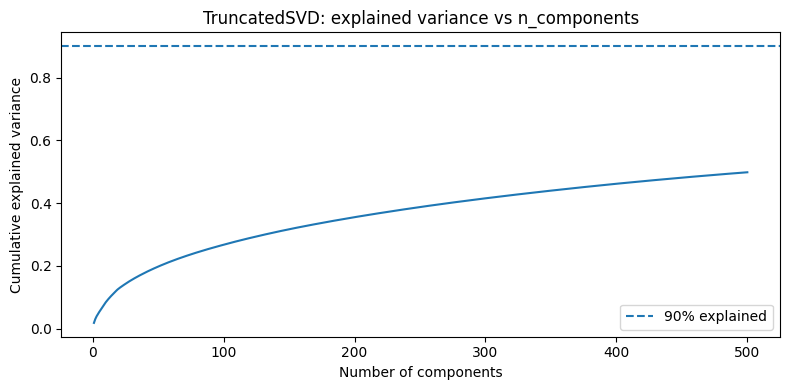

In [ ]:
from sklearn.decomposition import TruncatedSVD

max_components = 500
svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(X_tfidf)

# 3. Считаем кумулятивную долю объяснённой дисперсии
explained_var = svd_full.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# 4. Строим график «число компонент ↔ накопленная дисперсия»
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, max_components + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("TruncatedSVD: explained variance vs n_components")
plt.axhline(y=0.90, linestyle='--', label='90% explained')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)

# fit только на train
X_svd_train = svd.fit_transform(X_tfidf)  # shape (n_train, 100)
# transform — на test
# X_svd_test  = svd.transform(X_tfidf_test)       # shape (n_test, 100)

In [ ]:
svd_cols = [f"svd_{i+1}" for i in range(X_svd_train.shape[1])]

# 1) Создаём DataFrame из массива, сохраняя тот же индекс, что и X_train
df_svd_train = pd.DataFrame(
    X_svd_train,
    columns=svd_cols,
    index=X_train.index  # если X_train — ваш исходный DataFrame train
)

# 2) Теперь конкатенируем по столбцам
X_train_ = pd.concat([X_train, df_svd_train], axis=1)

print(X_train_.shape)
X_train_.head()

(112644, 105)


,content,name,owners,model_score,clean_content,svd_1,svd_2,svd_3,svd_4,svd_5,...,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99,svd_100
27887,i miss csgo,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000",0.252871,miss csgo,0.004093,0.007260,0.002601,-0.001552,-0.008503,...,0.022792,0.019876,0.024685,-0.005296,0.001731,-0.010000,-0.002065,-0.001481,0.004405,0.004229
89458,2/10 no fish ai,Counter-Strike: Source,"10,000,000 .. 20,000,000",0.791153,fish ai,0.001951,0.003455,0.001647,-0.001301,-0.003701,...,-0.006088,0.004215,-0.002734,0.002491,-0.000514,0.001197,-0.001273,0.002263,0.000080,-0.002456
47101,"This game is so silly because I shoot the ""inf...",Left 4 Dead 2,"50,000,000 .. 100,000,000",0.489242,game silly shoot infected people go aaieeehage...,0.219945,0.069674,-0.031989,-0.017647,0.000565,...,-0.029685,-0.022919,0.003219,0.003342,-0.009176,-0.027454,-0.001503,-0.023898,0.003315,-0.025393
18725,You've managed to make me not care about the c...,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000",0.444210,managed make care continuation ending ip enjoy...,0.007306,0.013641,0.003458,-0.004260,-0.011710,...,-0.008782,0.018539,-0.014488,0.008755,0.015278,-0.010603,0.000691,-0.000637,-0.011128,-0.003780
21403,I don't recommend this because Left 4 Dead 2 i...,Left 4 Dead,"5,000,000 .. 10,000,000",0.000905,recommend left dead superior every way making ...,0.088247,0.153092,-0.027744,-0.017853,-0.015169,...,-0.044416,-0.001711,-0.019256,0.010600,-0.000488,0.057420,-0.041057,-0.041728,0.013237,-0.077809


In [ ]:
X_train_['content_length'] = X_train_['content'].str.len().fillna(0)
X_train_['open_paren_count']  = X_train_['content'].str.count(r'\(').fillna(0)
X_train_['close_paren_count'] = X_train_['content'].str.count(r'\)').fillna(0)

X_train_['exclamation_count'] = X_train_['content'].str.count(r'!').fillna(0)
X_train_['question_count']    = X_train_['content'].str.count(r'\?').fillna(0)

X_train_['digit_count'] = X_train_['content'].str.count(r'\d').fillna(0)

X_train_['uppercase_word_count'] = X_train_['content'].astype(str).apply(
        lambda text: sum(1 for w in text.split() if w.isupper())
).fillna(0)

X_train_['punctuation_count'] = X_train_['content'].str.count(r'[^\w\s]').fillna(0)

In [ ]:
X_test_['content_length'] = X_test_['content'].str.len().fillna(0)
X_test_['open_paren_count']  = X_test_['content'].str.count(r'\(').fillna(0)
X_test_['close_paren_count'] = X_test_['content'].str.count(r'\)').fillna(0)

X_test_['exclamation_count'] = X_test_['content'].str.count(r'!').fillna(0)
X_test_['question_count']    = X_test_['content'].str.count(r'\?').fillna(0)

X_test_['digit_count'] = X_test_['content'].str.count(r'\d').fillna(0)

X_test_['uppercase_word_count'] = X_test_['content'].astype(str).apply(
        lambda text: sum(1 for w in text.split() if w.isupper())
).fillna(0)

X_test_['punctuation_count'] = X_test_['content'].str.count(r'[^\w\s]').fillna(0)

In [ ]:
test_texts  = X_test ['clean_content'].astype(str).tolist()

X_test_tfidf = vectorizer.transform(test_texts)


X_svd_test  = svd.transform(X_test_tfidf)

df_svd_test = pd.DataFrame(
    X_svd_test,
    columns=svd_cols,
    index=X_test.index
)
X_test_ = pd.concat([X_test, df_svd_test], axis=1)

In [ ]:
X_test_

,content,name,owners,model_score,clean_content,svd_1,svd_2,svd_3,svd_4,svd_5,...,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99,svd_100
130640,THE BEST MULTIPLAYER WORLD WAR 2 GAME PERIOD! ...,Day of Defeat: Source,"5,000,000 .. 10,000,000",0.888361,best multiplayer world war game period believe...,0.071192,0.129824,-0.012346,0.060354,0.006457,...,-0.004840,-0.000371,0.010741,-0.009818,-0.004983,-0.002056,0.004064,0.023770,0.004971,-0.002600
24201,herp da derpa derp,Alien Swarm,"2,000,000 .. 5,000,000",0.950827,herp da derpa derp,0.000475,0.001084,-0.000373,0.001013,-0.000066,...,-0.012340,0.010936,-0.001585,0.013048,-0.011139,0.002742,-0.001275,0.014923,0.010960,-0.015974
36855,"in the tail end of 2014, my dad introduced me ...",Counter-Strike,"10,000,000 .. 20,000,000",0.819218,tail end dad introduced hand ipad kid afterwhi...,0.050378,0.093161,-0.002062,-0.015834,-0.049414,...,0.028432,0.020428,-0.025996,0.042891,0.004342,-0.027473,-0.040204,0.066668,0.089851,-0.037287
9970,"Well, it might was a good game back then. Sing...",Counter-Strike: Condition Zero,"2,000,000 .. 5,000,000",0.014441,well might good game back campaigns really bad...,0.179036,0.045046,-0.018483,-0.059374,-0.106784,...,-0.053347,-0.005699,-0.034671,-0.008178,-0.007186,-0.008364,-0.000019,0.024981,0.011383,-0.010479
79835,Spend your time on higher ROI activities.,Dota 2,"200,000,000 .. 500,000,000",0.000073,spend time higher roi activities,0.008509,0.016882,0.004974,-0.001549,-0.012895,...,-0.002561,-0.008325,-0.000052,-0.000867,-0.014627,0.001089,0.007244,0.007692,-0.006739,-0.027296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94602,Best,Counter-Strike,"10,000,000 .. 20,000,000",0.980883,best,0.039559,0.117460,-0.078112,0.592808,0.179325,...,-0.005102,0.021495,0.008015,0.002554,0.020810,0.006392,0.028982,-0.013591,-0.015669,-0.012789
70881,source,Half-Life: Source,"2,000,000 .. 5,000,000",0.971220,source,0.012611,0.023215,0.012326,-0.010201,-0.032910,...,0.073856,-0.040119,0.028297,-0.036827,0.067637,-0.028320,0.007173,-0.020444,-0.020265,-0.000795
127530,was good at it time but not anymore need more ...,Half-Life 2: Lost Coast,"20,000,000 .. 50,000,000",0.896131,good time anymore need ppl play fun,0.194568,-0.009490,0.221095,0.011780,-0.015748,...,0.046088,-0.016194,0.041185,-0.037389,-0.028281,-0.065652,0.021648,-0.000926,-0.010762,0.010634
21668,I died. I am happy.\n\nI was black I survived....,Alien Swarm,"2,000,000 .. 5,000,000",0.950827,died happy black survived happy hacked survive...,0.003026,0.005861,0.001490,-0.002024,-0.005553,...,0.001187,0.002358,0.008126,0.006108,-0.015311,0.005521,0.002539,0.019338,0.001808,-0.005958


In [ ]:
from catboost import CatBoostClassifier

model_ = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100,
    cat_features=['name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_train_.drop(['content', 'clean_content'], axis=1),
    y_train,
    use_best_model=True,
    # plot=True
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6071692	total: 50.4ms	remaining: 50.4s
100:	learn: 0.2550087	total: 5.02s	remaining: 44.7s
200:	learn: 0.2380413	total: 9.94s	remaining: 39.5s
300:	learn: 0.2261370	total: 14.9s	remaining: 34.7s
400:	learn: 0.2171269	total: 19.9s	remaining: 29.7s
500:	learn: 0.2096842	total: 24.9s	remaining: 24.8s
600:	learn: 0.2026056	total: 29.8s	remaining: 19.8s
700:	learn: 0.1966135	total: 34.8s	remaining: 14.9s
800:	learn: 0.1908627	total: 40.1s	remaining: 9.96s
900:	learn: 0.1852935	total: 45.1s	remaining: 4.95s
999:	learn: 0.1801131	total: 50s	remaining: 0us


In [ ]:
y_pred = model_.predict(X_test_.drop(['content', 'clean_content'], axis=1))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8962394801320975

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89     13788
           1       0.88      0.92      0.90     14373

    accuracy                           0.90     28161
   macro avg       0.90      0.90      0.90     28161
weighted avg       0.90      0.90      0.90     28161


Confusion Matrix:
 [[11944  1844]
 [ 1078 13295]]


In [ ]:
  X_train_['owners'].unique()

array(['100,000,000 .. 200,000,000', '10,000,000 .. 20,000,000',
       '50,000,000 .. 100,000,000', '5,000,000 .. 10,000,000',
       '200,000,000 .. 500,000,000', '1,000,000 .. 2,000,000',
       '20,000,000 .. 50,000,000', '-', '2,000,000 .. 5,000,000'],
      dtype=object)

In [ ]:
import numpy as np
import pandas as pd

def parse_owners(x):
    # если пропуск, возвращаем NaN
    if x.strip() == '-' or pd.isna(x):
        return np.nan
    # разделяем по „..“
    lo, hi = x.split('..')
    lo = int(lo.replace(',', '').strip())
    hi = int(hi.replace(',', '').strip())
    return (lo + hi) / 2

# 1) Преобразуем в численный столбец
X_train_['owners_num'] = X_train_['owners'].apply(parse_owners)
X_test_ ['owners_num'] = X_test_ ['owners'].apply(parse_owners)

# 2) Заполняем NaN медианой по train
median_owners = X_train_['owners_num'].median()
X_train_['owners_num'].fillna(median_owners, inplace=True)
X_test_ ['owners_num'].fillna(median_owners, inplace=True)

# 3) (опционально) Удаляем старый текстовый признак
# X_train_ = X_train_.drop(columns=['owners'])
# X_test_  = X_test_.drop(columns=['owners'])

# 4) Смотрим результат
print("Новые признак owners_num в X_train_:",
      X_train_['owners_num'].describe())
X_train_.head()


Новые признак owners_num в X_train_: count    1.126440e+05
mean     7.334334e+07
std      1.034488e+08
min      1.500000e+06
25%      7.500000e+06
50%      1.500000e+07
75%      7.500000e+07
max      3.500000e+08
Name: owners_num, dtype: float64


<ipython-input-41-b76715866301>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_['owners_num'].fillna(median_owners, inplace=True)
<ipython-input-41-b76715866301>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

,content,name,owners,model_score,clean_content,svd_1,svd_2,svd_3,svd_4,svd_5,...,svd_100,content_length,open_paren_count,close_paren_count,exclamation_count,question_count,digit_count,uppercase_word_count,punctuation_count,owners_num
27887,i miss csgo,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000",0.252871,miss csgo,0.004093,0.007260,0.002601,-0.001552,-0.008503,...,0.004229,11,0,0,0,0,0,0,0,150000000.0
89458,2/10 no fish ai,Counter-Strike: Source,"10,000,000 .. 20,000,000",0.791153,fish ai,0.001951,0.003455,0.001647,-0.001301,-0.003701,...,-0.002456,15,0,0,0,0,3,0,1,15000000.0
47101,"This game is so silly because I shoot the ""inf...",Left 4 Dead 2,"50,000,000 .. 100,000,000",0.489242,game silly shoot infected people go aaieeehage...,0.219945,0.069674,-0.031989,-0.017647,0.000565,...,-0.025393,180,0,0,3,0,0,3,8,75000000.0
18725,You've managed to make me not care about the c...,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000",0.444210,managed make care continuation ending ip enjoy...,0.007306,0.013641,0.003458,-0.004260,-0.011710,...,-0.003780,127,0,0,0,0,1,1,4,7500000.0
21403,I don't recommend this because Left 4 Dead 2 i...,Left 4 Dead,"5,000,000 .. 10,000,000",0.000905,recommend left dead superior every way making ...,0.088247,0.153092,-0.027744,-0.017853,-0.015169,...,-0.077809,139,0,0,0,0,4,3,3,7500000.0


In [ ]:
from catboost import CatBoostClassifier

model_ = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100,
    cat_features=['name'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_train_.drop(['content', 'clean_content', 'owners'], axis=1),
    y_train,
    use_best_model=True,
    # plot=True
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6054028	total: 42.6ms	remaining: 42.6s
100:	learn: 0.2556572	total: 4.97s	remaining: 44.3s
200:	learn: 0.2381618	total: 9.65s	remaining: 38.3s
300:	learn: 0.2267154	total: 14.3s	remaining: 33.2s
400:	learn: 0.2175955	total: 19.5s	remaining: 29.1s
500:	learn: 0.2101642	total: 24.6s	remaining: 24.5s
600:	learn: 0.2032670	total: 29.3s	remaining: 19.4s
700:	learn: 0.1966379	total: 33.9s	remaining: 14.5s
800:	learn: 0.1907925	total: 38.6s	remaining: 9.6s
900:	learn: 0.1854625	total: 43.3s	remaining: 4.76s
999:	learn: 0.1805345	total: 48.1s	remaining: 0us


In [ ]:
y_pred = model_.predict(X_test_.drop(['content', 'clean_content', 'owners'], axis=1))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8963105003373459

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89     13788
           1       0.88      0.92      0.90     14373

    accuracy                           0.90     28161
   macro avg       0.90      0.90      0.90     28161
weighted avg       0.90      0.90      0.90     28161


Confusion Matrix:
 [[11948  1840]
 [ 1080 13293]]
